<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/RECONOCIMIENTO-DE-FORMAS-Y-APRENDIZAJE-COMPUTACIONAL/blob/main/SEMANA%205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEMANA 5
Tema. APRENDIZAJE SUPERVISADO

2.7.1. Preprocesamiento de datos.

2.8. Sobreajuste y validación cruzada.

2.9. Aplicaciones prácticas.

2.10. Retos y consideraciones éticas.

Objetivo: Comprender la importancia del preprocesamiento de datos, la detección y prevención del sobreajuste mediante técnicas como la validación cruzada, y reconocer cómo estos aspectos influyen en la aplicación práctica de los modelos supervisados. Además, analizar las implicaciones éticas asociadas al uso de aprendizaje automático en distintos contextos, desarrollando la capacidad de aplicar modelos de forma responsable, fundamentada y consciente de sus limitaciones.

# Semana 5 – Proceso general y uso de la validación cruzada
# 🫀 Proyecto: Predicción de Enfermedad Cardiovascular (EDA → Preprocesamiento → PCA → CV)

## 1) Importación y vista general
**Objetivo:** cargar el dataset y entender su estructura (filas, columnas, tipos).

**Qué mirar:** forma del DataFrame, tipos de datos, primeras filas y la variable objetivo `cardio`.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier


## 1) Cargar datos y separar X/y
- Carga desde CSV.
- Revisa forma (filas/columnas) y tipos de datos.
- Quita columnas no predictivas (ej. ID).


In [ ]:
# Carga
df = pd.read_csv("cardio_train.csv")

# Limpieza mínima
if "id" in df.columns:
    df = df.drop(columns=["id"])

# Target
target_col = "cardio"  # en este dataset la etiqueta suele llamarse 'cardio'
y = df[target_col].astype(int).values
X = df.drop(columns=[target_col]).copy()

# Reemplazar infinitos por NaN (por si acaso), pero NO imputamos aún
X = X.replace([np.inf, -np.inf], np.nan)



## 2) EDA mínimo
**Objetivo:** tener un diagnóstico rápido.

- **Distribución del target**: comprobar desbalance entre 0/1.
- **`describe()`**: detectar escalas muy distintas y valores extraños.
- **Nulos**: cuántos y dónde (aunque simulemos algunos para enseñar imputación).


In [ ]:
# EDA básico
print("Dimensiones:", df.shape)
print(df.info())
display(df.describe().T.head())

# Balance de clases
print("Distribución del target:")
display(df["cardio"].value_counts(normalize=True))




Dimensiones: (70000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB
None


,count,mean,std,min,25%,50%,75%,max
age,70000.0,19468.865814,2467.251667,10798.0,17664.0,19703.0,21327.0,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.0,1.0,2.0,2.0
height,70000.0,164.359229,8.210126,55.0,159.0,165.0,170.0,250.0
weight,70000.0,74.205690,14.395757,10.0,65.0,72.0,82.0,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.0,120.0,140.0,16020.0


Distribución del target:


,proportion
cardio,
0,0.5003
1,0.4997


## 3) Simulación de nulos (didáctica)
**Objetivo:** introducir valores faltantes controlados para practicar **imputación**.

- Inyectamos NaN (ej. 5%) en `cholesterol`.
- Volvemos a contar nulos para verificar la simulación.


In [ ]:
# Simular valores faltantes en cholesterol (5%)
rng = np.random.default_rng(42)
mask = rng.random(X.shape[0]) < 0.05
X.loc[mask, "cholesterol"] = np.nan

print("Valores nulos después de simular:")
display(X.isna().sum().sort_values(ascending=False).head())

Valores nulos después de simular:


,0
cholesterol,3502
gender,0
age,0
height,0
weight,0


## 4) Imputación de datos
**Objetivo:** manejar faltantes **sin fuga** (en exploración lo hacemos global; en entrenamiento será por fold).

- **Numéricas continuas** (`age`, `height`, `weight`, `ap_hi`, `ap_lo`): **mediana** (robusta a outliers).
- **Categóricas/ordinales** (`cholesterol`, `gluc`, `smoke`, `alco`, `active`): **moda**.
- **Nota de calidad**: `age` viene en **días** → transformarla a **años** para interpretabilidad.


In [ ]:
# --- IMPUTACIÓN DE DATOS ---

# Copiamos X para no perder el estado original (el EDA ya se hizo sobre X)
X_imp = X.copy()

# 1) Columnas numéricas continuas (mediana)
num_cols = ["age", "height", "weight", "ap_hi", "ap_lo"]
for c in num_cols:
    if c in X_imp.columns:
        X_imp[c] = X_imp[c].fillna(X_imp[c].median())

# 2) Columnas categóricas ordinales/discretas (moda)
#   cholesterol y gluc están codificadas (1, 2, 3); smoke/alco/active son 0/1
cat_cols = [col for col in ["cholesterol", "gluc", "smoke", "alco", "active"] if col in X_imp.columns]
for c in cat_cols:
    mode_val = X_imp[c].mode(dropna=True)
    if not mode_val.empty:
        X_imp[c] = X_imp[c].fillna(mode_val.iloc[0])

# Verificación de nulos post-imputación
print("Nulos tras imputación (top 10):")
display(X_imp.isna().sum().sort_values(ascending=False).head(10))

# Transformar edad de días a años (aprox. 365 días por año)
if "age" in X_imp.columns:
    X_imp["age"] = (X_imp["age"] / 365).round().astype(int)

# Verificación rápida
print("Edad en años:")
print(X_imp["age"].describe())


Nulos tras imputación (top 10):


,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0
alco,0


Edad en años:
count    70000.000000
mean        53.338686
std          6.765294
min         30.000000
25%         48.000000
50%         54.000000
75%         58.000000
max         65.000000
Name: age, dtype: float64


## 5) Detección y tratamiento de valores anómalos (outliers)
**Objetivo:** corregir valores irreales sin eliminar filas.

- **Clipping clínico** (reglas médicas): p. ej., `ap_lo` ∈ [40, 200].
- **Winsorización** (1% en extremos): recorta colas largas de forma estadística.
- **Comparativa visual**: *boxplots* de `Raw` vs `Clipping+Winsor`.
- **Idea clave:** no borrar datos; **corregir** con criterios clínicos/estadísticos.


             height        weight         ap_hi         ap_lo
count  70000.000000  70000.000000  70000.000000  70000.000000
mean     164.419486     74.118496    126.867443     93.794600
std        7.713344     13.796408     16.835775    106.195785
min      147.000000     48.000000     90.000000     60.000000
25%      159.000000     65.000000    120.000000     80.000000
50%      165.000000     72.000000    120.000000     80.000000
75%      170.000000     82.000000    140.000000     90.000000
max      184.000000    117.000000    180.000000   1000.000000


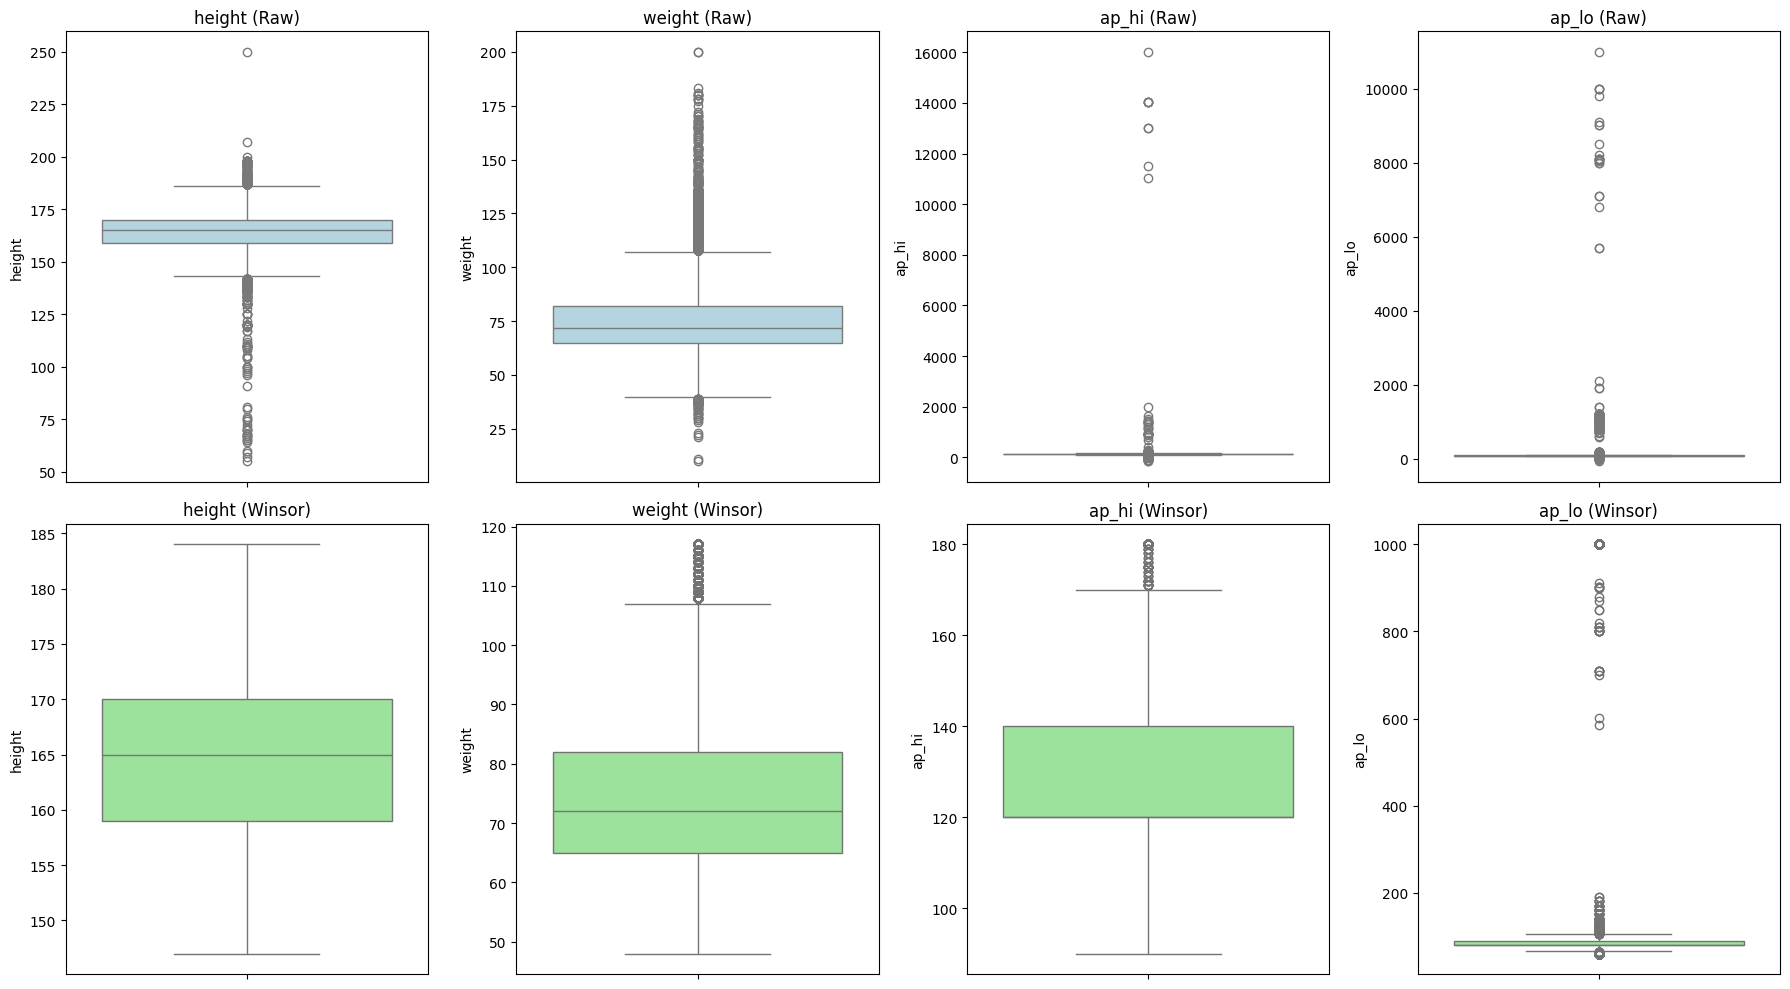

In [ ]:
from scipy.stats.mstats import winsorize

X_winsor = X_imp.copy()
X_raw = X_imp.copy()
for col in ["height", "weight", "ap_hi", "ap_lo"]:
    X_winsor[col] = winsorize(X_imp[col], limits=[0.01, 0.01])  # 1% en cada extremo

print(X_winsor[["height","weight","ap_hi","ap_lo"]].describe())
vars_to_plot = ["height", "weight", "ap_hi", "ap_lo"]

fig, axes = plt.subplots(2, len(vars_to_plot), figsize=(18,10))

for i, col in enumerate(vars_to_plot):
    # Original
    sns.boxplot(y=X_raw[col], ax=axes[0, i], color="lightblue")
    axes[0, i].set_title(f"{col} (Raw)")

    # Winsorizado
    sns.boxplot(y=X_winsor[col], ax=axes[1, i], color="lightgreen")
    axes[1, i].set_title(f"{col} (Winsor)")

plt.tight_layout()
plt.show()


ap_lo después de clipping + winsorización:
count    70000.000000
mean        82.996500
std         16.765277
min         60.000000
25%         80.000000
50%         80.000000
75%         90.000000
max        200.000000
Name: ap_lo, dtype: float64


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning:




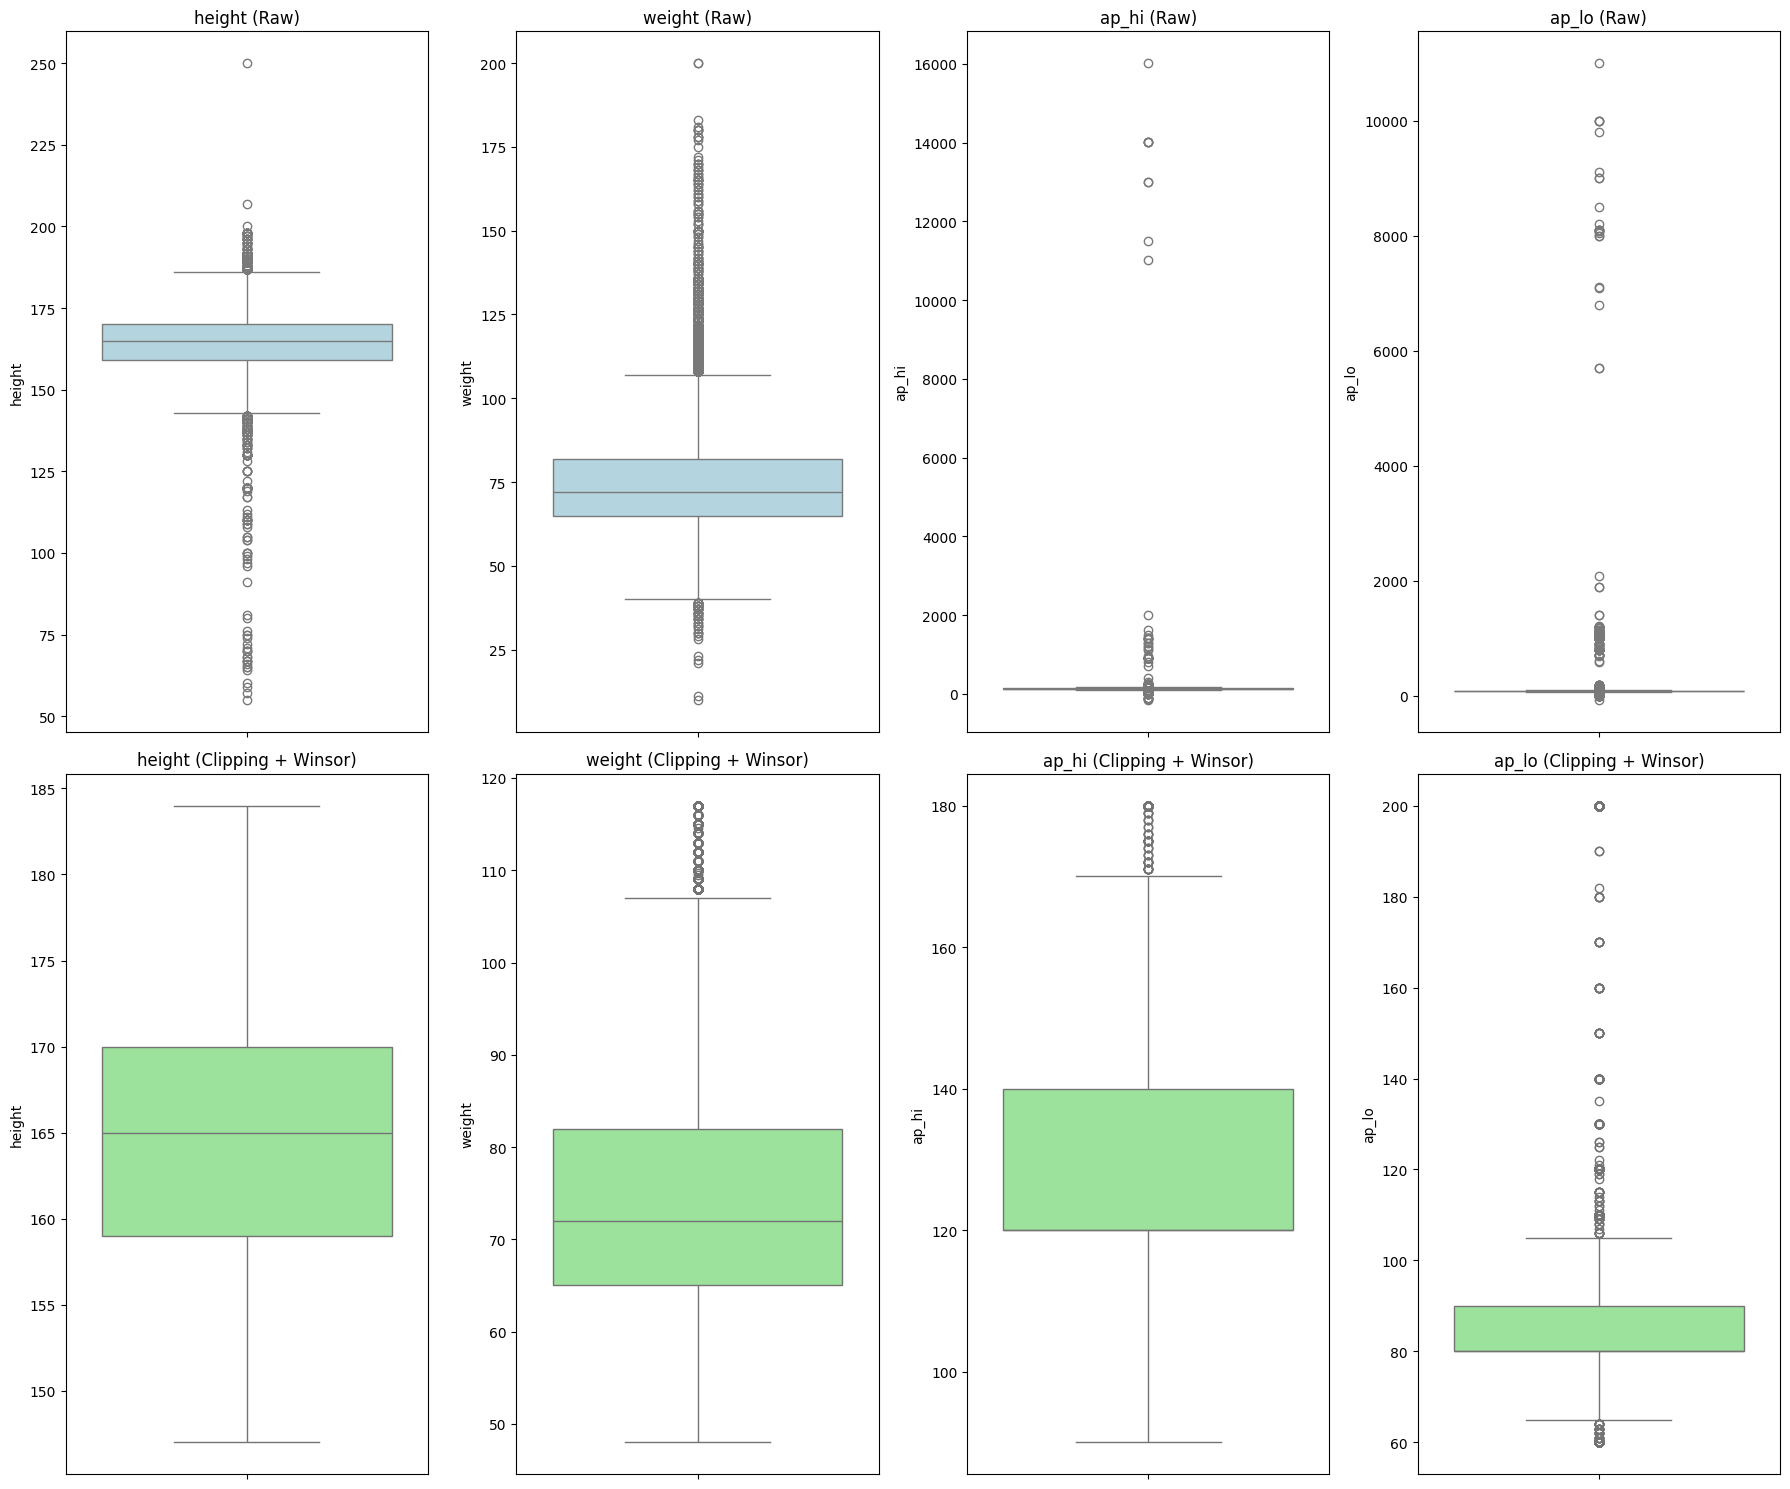

In [ ]:
from scipy.stats.mstats import winsorize

# Copias
X_raw = X_imp.copy()
X_winsor = X_imp.copy()

# Clipping clínico SOLO para ap_lo (40–200 mmHg)
X_winsor["ap_lo"] = X_winsor["ap_lo"].clip(lower=40, upper=200)

# Winsorización 1% (aplicada después del clipping)
for col in ["height", "weight", "ap_hi", "ap_lo"]:
    X_winsor[col] = winsorize(X_winsor[col], limits=[0.01, 0.01])

# Verificación rápida
print("ap_lo después de clipping + winsorización:")
print(X_winsor["ap_lo"].describe())

# --- Graficar ---
vars_to_plot = ["height", "weight", "ap_hi", "ap_lo"]

fig, axes = plt.subplots(2, len(vars_to_plot), figsize=(18,15))

for i, col in enumerate(vars_to_plot):
    # Original
    sns.boxplot(y=X_raw[col], ax=axes[0, i], color="lightblue")
    axes[0, i].set_title(f"{col} (Raw)")

    # Winsor + Clipping
    sns.boxplot(y=X_winsor[col], ax=axes[1, i], color="lightgreen")
    axes[1, i].set_title(f"{col} (Clipping + Winsor)")

plt.tight_layout()
plt.show()


# --- Prueba de Shapiro-Wilk para normalidad ---
# Tomamos solo las columnas numéricas relevantes

Prueba de normalidad (Shapiro-Wilk):

       age: W=0.965, p=0.000
    height: W=0.992, p=0.006
    weight: W=0.951, p=0.000
     ap_hi: W=0.902, p=0.000
     ap_lo: W=0.517, p=0.000

Interpretación:
- p > 0.05: no se rechaza la normalidad (parece normal).
- p <= 0.05: se rechaza la normalidad (no es normal).


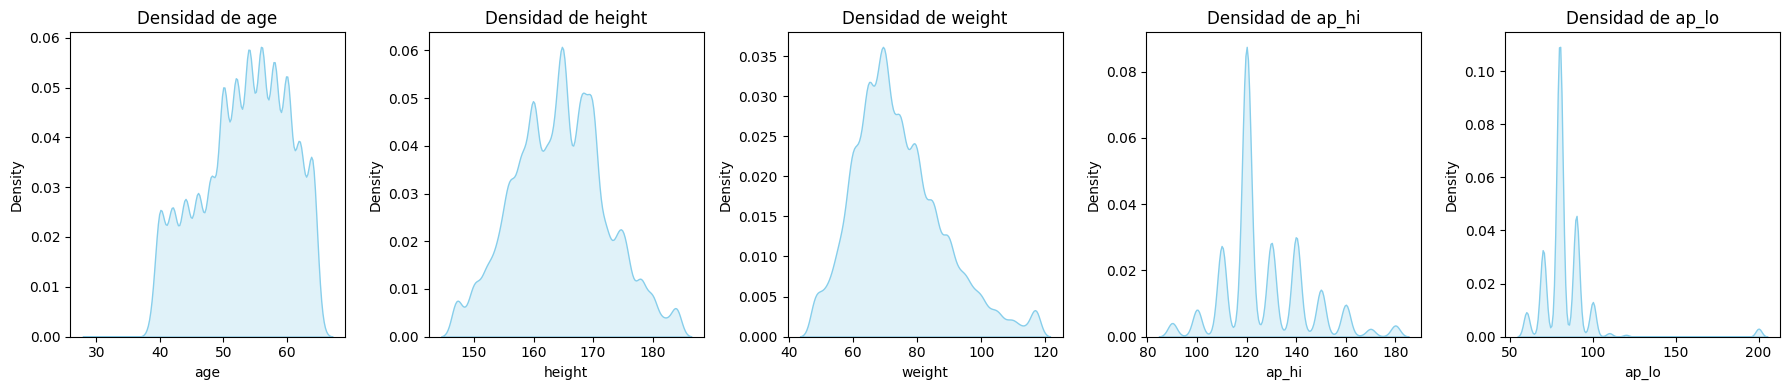

In [ ]:
print("Prueba de normalidad (Shapiro-Wilk):\n")
for col in num_cols:
    stat, p = shapiro(X_winsor[col].sample(500, random_state=42))  # sample para no saturar
    print(f"{col:>10}: W={stat:.3f}, p={p:.3f}")

print("\nInterpretación:")
print("- p > 0.05: no se rechaza la normalidad (parece normal).")
print("- p <= 0.05: se rechaza la normalidad (no es normal).")

# --- Gráficos de densidad ---
fig, axes = plt.subplots(1, len(num_cols), figsize=(18, 4))
for i, col in enumerate(num_cols):
    sns.kdeplot(X_winsor[col], ax=axes[i], fill=True, color="skyblue")
    axes[i].set_title(f"Densidad de {col}")
plt.tight_layout()
plt.show()


## 6) Escalado / Normalización
**Objetivo:** poner las variables en escalas comparables.

- **StandardScaler** (media=0, std=1) → recomendado para LogReg/KNN/SVM/MLP.
- **Normalizer** (por fila) → útil para KNN/SVM en algunos casos; en tabular suele ganar StandardScaler.
- **Gráficos**: boxplots y dispersión antes/después del escalado.


In [ ]:
# --- ESCALADO / NORMALIZACIÓN ---

# Elegimos StandardScaler (media=0, std=1) para los continuos
scaler = StandardScaler()

X_scaled = X_winsor.copy()
cols_to_scale = [c for c in num_cols if c in X_scaled.columns]

X_scaled[cols_to_scale] = scaler.fit_transform(X_imp[cols_to_scale])

# (Opcional) También podrías probar MinMaxScaler:
#mm = MinMaxScaler()
mm = Normalizer()
X_mm = X_winsor.copy()
X_mm[cols_to_scale] = mm.fit_transform(X_imp[cols_to_scale])
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html

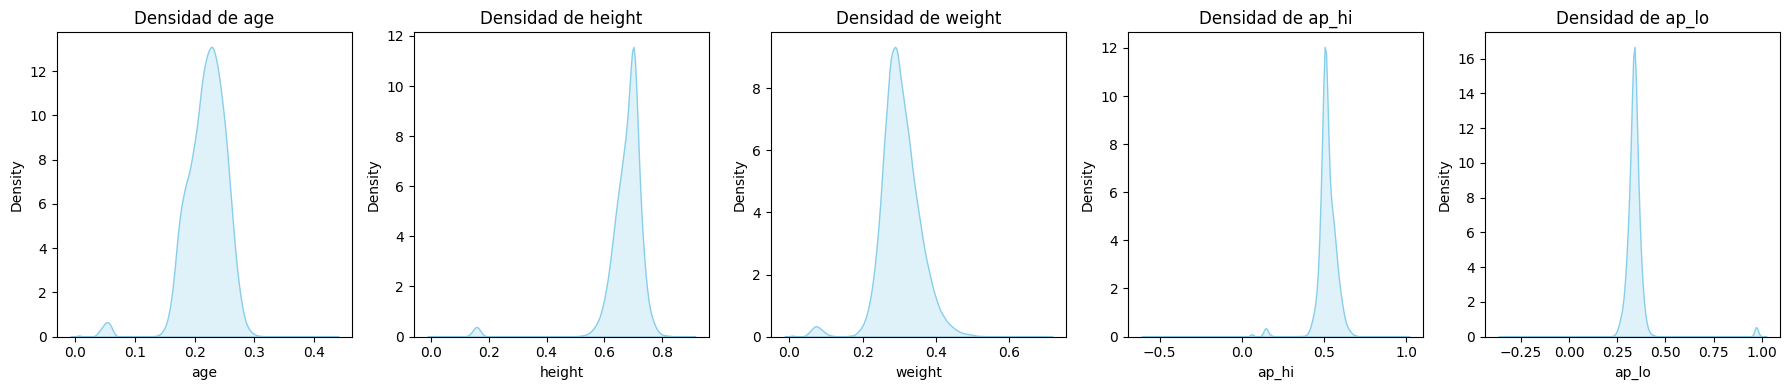

In [ ]:
fig, axes = plt.subplots(1, len(num_cols), figsize=(18, 4))
for i, col in enumerate(num_cols):
    sns.kdeplot(X_mm[col], ax=axes[i], fill=True, color="skyblue")
    axes[i].set_title(f"Densidad de {col}")
plt.tight_layout()
plt.show()

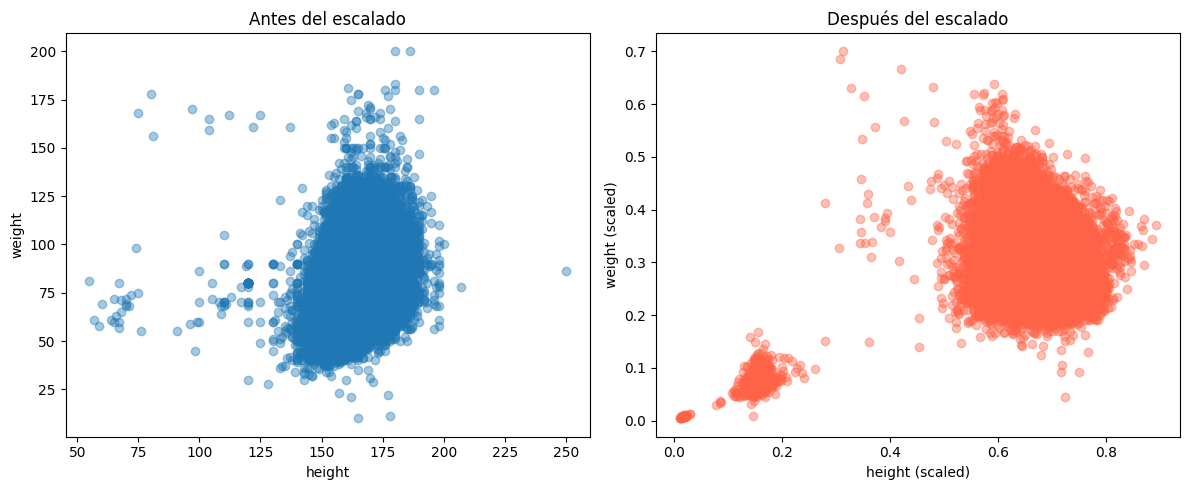

In [ ]:
plt.figure(figsize=(12,5))

# Ejemplo 1: peso vs. altura
plt.subplot(1,2,1)
plt.scatter(X_imp["height"], X_imp["weight"], alpha=0.4)
plt.xlabel("height"); plt.ylabel("weight")
plt.title("Antes del escalado")

plt.subplot(1,2,2)
plt.scatter(X_mm["height"], X_mm["weight"], alpha=0.4, color="tomato")
plt.xlabel("height (scaled)"); plt.ylabel("weight (scaled)")
plt.title("Después del escalado")

plt.tight_layout()
plt.show()



## 7) PCA (2D y 3D) para ver la dispersión de los datos
**Objetivo:** reducir dimensiones para *ver* la estructura.

- **PCA 2D**: visualizar `PC1` vs `PC2` coloreando por etiqueta (`cardio`).
- **PCA 3D**: gráfico interactivo (plotly) `PC1–PC2–PC3`.
- **Mensaje docente:** en 2–3D rara vez hay separación perfecta; los modelos supervisados aprovechan **todas** las variables.


Varianza explicada por los 2 primeros componentes: [0.43039404 0.1855629  0.16031025]


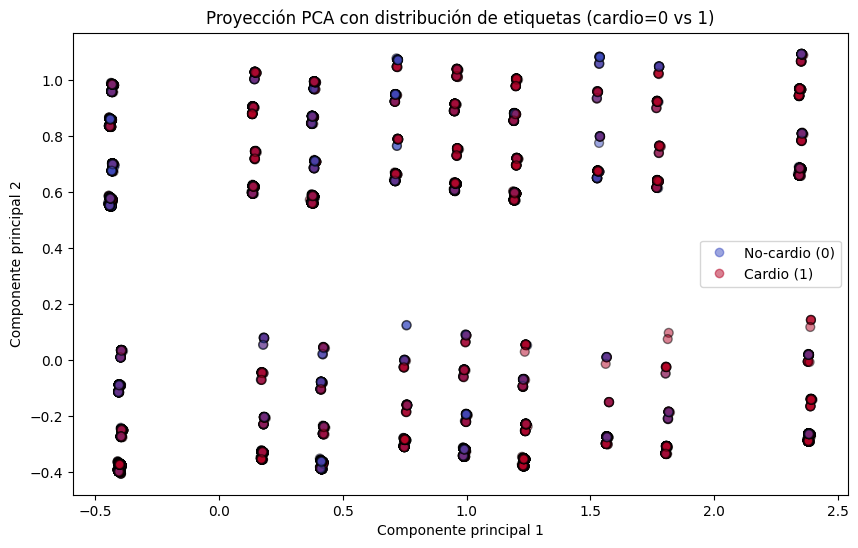

In [ ]:
from sklearn.decomposition import PCA

# --- PCA con datos escalados ---
pca = PCA(n_components=3)
#X_pca = pca.fit_transform(X_imp)
#X_pca = pca.fit_transform(X_scaled)
X_pca = pca.fit_transform(X_mm)

print("Varianza explicada por los 2 primeros componentes:", pca.explained_variance_ratio_)

# --- Gráfico PCA ---
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=y, cmap="coolwarm", alpha=0.5, edgecolor="k", s=40
)

plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.title("Proyección PCA con distribución de etiquetas (cardio=0 vs 1)")
plt.legend(handles=scatter.legend_elements()[0], labels=["No-cardio (0)", "Cardio (1)"])
plt.show()


In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA
#X_imp##Imputada
#X_mm##Normalizada
#X_scaled##Escalada

# --- PCA a 3 componentes ---
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_imp)

# Crear DataFrame con etiquetas
principalDf = pd.DataFrame(
    data = X_pca3,
    columns = ["x", "y", "z"]
)
principalDf["label"] = y  # 0 = no-cardio, 1 = cardio

# --- Gráfico 3D interactivo ---
fig = px.scatter_3d(
    principalDf, x='x', y='y', z='z',
    color=principalDf["label"].astype(str),  # convertir a str para mejor leyenda
    opacity=0.6,
    title="Proyección PCA 3D con etiquetas"
)
fig.show()


## 🔹 Relación entre los diferentes datasets

Durante el preprocesamiento generamos varias versiones de los datos:

- **`X_imp` → Imputada**: datos originales con valores faltantes rellenados (mediana/moda).  
- **`X_scaled` → Escalada**: variables numéricas transformadas con *StandardScaler* (media 0, desviación 1).  
- **`X_mm` → Normalizada**: cada fila tratada como vector unitario (*Normalizer*).  

En este bloque haremos el **split en train/test** y aplicaremos de nuevo escalado y normalización solo con los datos de entrenamiento, para evitar fuga de información.



In [ ]:
from sklearn.neural_network import MLPClassifier

# --- Split a partir de los datasets ya preprocesados ---
# Usamos X_scaled para StandardScaler y X_mm para Normalizer
X_train_sc, X_test_sc, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

X_train_mm, X_test_mm, _, _ = train_test_split(
    X_mm, y, test_size=0.3, random_state=42, stratify=y
)

# ------------- Función para elegir dataset según el modelo -------------
def pick_matrix(kind):
    if kind == "std":   return X_train_sc, X_test_sc
    if kind == "norm":  return X_train_mm, X_test_mm
    return X_train_sc, X_test_sc   # por defecto raw → aquí usamos escalado



## 8) Split train/test clasico
**Objetivo:** reservar un conjunto **de prueba** para evaluación final (sin fuga).

- `train_test_split` con `stratify=y` para mantener proporciones de clases.


In [ ]:
####Tiempo de ejecucion 17 minutos
from sklearn.neural_network import MLPClassifier

models = {
    "LogReg_STD":   ("norm",  LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)),
    "KNN_STD":      ("norm",  KNeighborsClassifier(n_neighbors=11)),
    #"SVM_RBF_STD":  ("norm",  SVC(probability=True, class_weight="balanced", random_state=42)),
    "RandomForest": ("std",  RandomForestClassifier(n_estimators=400, random_state=42)),

    # # 👇 MLP con escalado
    "MLP_STD": ("std", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        alpha=1e-4,             # regularización L2
        learning_rate="adaptive",
        max_iter=400,           # subir a 300 para convergencia
        early_stopping=True,    # valida internamente
        n_iter_no_change=5,
        random_state=42
    )),
}


# --- Entrenar y evaluar como ya lo hacías ---
rows, preds = [], {}
for name, (kind, clf) in models.items():
    Xtr, Xte = pick_matrix(kind)
    clf.fit(Xtr, y_train)
    y_pred = clf.predict(Xte)
    preds[name] = y_pred

    # métricas
    row = {
        "model": name,
        "accuracy":  accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall":    recall_score(y_test, y_pred, zero_division=0),
        "f1":        f1_score(y_test, y_pred, zero_division=0),
    }
    # AUC si hay proba o decision_function
    try:
        y_score = clf.predict_proba(Xte)[:,1]
        row["roc_auc"] = roc_auc_score(y_test, y_score)
    except Exception:
        try:
            y_score = clf.decision_function(Xte)
            row["roc_auc"] = roc_auc_score(y_test, y_score)
        except Exception:
            row["roc_auc"] = np.nan

    rows.append(row)

results_df = pd.DataFrame(rows).set_index("model").sort_values("f1", ascending=False)
print(results_df.round(3))

best = results_df.index[0]
print(f"\nMejor por F1: {best}\n")
print(classification_report(y_test, preds[best], target_names=["No-cardio (0)","Cardio (1)"]))
print("Matriz de confusión:\n", confusion_matrix(y_test, preds[best]))


              accuracy  precision  recall     f1  roc_auc
model                                                    
MLP_STD          0.731      0.753   0.688  0.719    0.797
RandomForest     0.707      0.709   0.702  0.705    0.762
LogReg_STD       0.711      0.729   0.670  0.698    0.767
KNN_STD          0.704      0.711   0.686  0.698    0.758

Mejor por F1: MLP_STD

               precision    recall  f1-score   support

No-cardio (0)       0.71      0.77      0.74     10506
   Cardio (1)       0.75      0.69      0.72     10494

     accuracy                           0.73     21000
    macro avg       0.73      0.73      0.73     21000
 weighted avg       0.73      0.73      0.73     21000

Matriz de confusión:
 [[8137 2369]
 [3270 7224]]


## 📊 Prueba con tres modelos

Se entrenaron y evaluaron tres modelos de clasificación sobre el conjunto de datos cardiovascular.  
Las métricas comparadas fueron: **accuracy, precision, recall, F1 y ROC-AUC**.

| Modelo         | Accuracy | Precision | Recall | F1   | ROC-AUC |
|----------------|----------|-----------|--------|------|---------|
| RandomForest   | 0.707    | 0.709     | 0.702  | 0.705| 0.762   |
| LogReg_STD     | 0.711    | 0.729     | 0.670  | 0.698| 0.767   |
| KNN_STD        | 0.704    | 0.711     | 0.686  | 0.698| 0.758   |

👉 **Mejor por F1: RandomForest**  

---

### 📌 Reporte de clasificación
- **No-cardio (0):** precisión 0.71, recall 0.71, F1 0.71  
- **Cardio (1):** precisión 0.71, recall 0.70, F1 0.71  

**Accuracy total:** 0.71  
**Promedio macro y ponderado:** 0.71  

---

### 🔹 Matriz de confusión

|                | Pred. No-cardio | Pred. Cardio |
|----------------|-----------------|--------------|
| **Real No-cardio** | 7483            | 3023         |
| **Real Cardio**    | 3129            | 7365         |

---


## 🔹 Validación cruzada (5 folds)

En este bloque comparamos dos modelos (Logistic Regression y Random Forest) usando **validación cruzada estratificada (5-fold CV)**:

1. **Idea de CV:** en lugar de una sola división train/test, se hacen varias (5 folds).  
   - Cada fold entrena en el 80% y valida en el 20%.  
   - Al final, promediamos las métricas → resultados más robustos y estables.  

2. **Estratificación:**  
   - Se usa `StratifiedKFold`, que asegura que en cada fold la proporción de clases (ej. sanos vs enfermos) sea **igual** a la del dataset completo.  
   - Esto es clave en problemas desbalanceados: si no estratificamos, podríamos tener un fold con casi puros pacientes sanos y las métricas serían engañosas.  

3. **Logistic Regression (STD):**  
   - Requiere **escalado** → se aplica dentro de cada fold para evitar *data leakage*.  
   - Métricas: accuracy, precisión, recall, F1 y ROC-AUC.  

4. **Random Forest (RAW):**  
   - No requiere escalado (trabaja con divisiones de variables).  
   - Solo se hace imputación por mediana en cada fold.  

5. **Reporte:**  
   - Se imprimen **media ± desviación estándar** de cada métrica.  
   - Así evaluamos no solo el desempeño promedio, sino también la **estabilidad** del modelo entre folds.  

👉 **Enseñanza final:**  
- Los modelos lineales/neuronales dependen del escalado, los árboles no.  
- La estratificación garantiza comparaciones justas y métricas más representativas del problema real.  


In [ ]:
# --- IMPORTS BÁSICOS ---
from sklearn.model_selection import StratifiedKFold
# --- SPLIT: 70% train / 30% test, estratificado para mantener proporción de clases ---
X_train, X_test, y_train, y_test = train_test_split(
    X_winsor, y, test_size=0.30, stratify=y, random_state=42
)

# --- Columnas numéricas que escalaremos para la regresión logística ---
num_cols = [c for c in ["age", "height", "weight", "ap_hi", "ap_lo"] if c in X_train.columns]

# --- Configuración de validación cruzada (5 folds estratificados) ---
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


In [ ]:
# OBJETIVO: evaluar LogReg con CV
# - Imputamos por mediana dentro del fold
# - Ajustamos StandardScaler solo con el fold de entrenamiento
# - Calculamos métricas en el fold de validación

lr = KNeighborsClassifier(n_neighbors=11)
lr_scores = []  # aquí guardaremos las métricas de cada fold

for tr_idx, va_idx in cv.split(X_train, y_train):
    # 1) separar fold train/valid
    X_tr, X_va = X_train.iloc[tr_idx].copy(), X_train.iloc[va_idx].copy()
    y_tr, y_va = y_train[tr_idx], y_train[va_idx]

    # 2) imputación por mediana (por si hay NaN)
    med = X_tr.median(numeric_only=True)
    X_tr = X_tr.fillna(med)
    X_va = X_va.fillna(med)

    # 3) escalado SOLO con estadísticas del fold de entrenamiento
    scaler = StandardScaler().fit(X_tr[num_cols])
    X_tr_sc = X_tr.copy()
    X_va_sc = X_va.copy()
    X_tr_sc[num_cols] = scaler.transform(X_tr[num_cols])
    X_va_sc[num_cols] = scaler.transform(X_va[num_cols])

    # 4) entrenar y predecir
    lr.fit(X_tr_sc, y_tr)
    y_pred = lr.predict(X_va_sc)

    # 5) probabilidades para AUC (siempre disponibles en LogReg)
    y_score = lr.predict_proba(X_va_sc)[:, 1]

    # 6) guardar métricas del fold
    lr_scores.append({
        "accuracy":  accuracy_score(y_va, y_pred),
        "precision": precision_score(y_va, y_pred, zero_division=0),
        "recall":    recall_score(y_va, y_pred, zero_division=0),
        "f1":        f1_score(y_va, y_pred, zero_division=0),
        "roc_auc":   roc_auc_score(y_va, y_score),
    })

# Promediar métricas de los 5 folds (y desviación estándar para ver estabilidad)
lr_mean = pd.DataFrame(lr_scores).mean().round(3)
lr_std  = pd.DataFrame(lr_scores).std().round(3)

print("Logistic Regression (CV 10-fold)  —  mean ± std")
for k in lr_mean.index:
    print(f"{k:>9}: {lr_mean[k]} ± {lr_std[k]}")


Logistic Regression (CV 10-fold)  —  mean ± std
 accuracy: 0.717 ± 0.005
precision: 0.727 ± 0.004
   recall: 0.696 ± 0.008
       f1: 0.711 ± 0.006
  roc_auc: 0.774 ± 0.005


In [ ]:
# OBJETIVO: evaluar RandomForest con CV
# - Árboles NO necesitan escalado
# - Sí imputamos por mediana dentro del fold para evitar fugas

rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf_scores = []

for tr_idx, va_idx in cv.split(X_train, y_train):
    # 1) fold train/valid
    X_tr, X_va = X_train.iloc[tr_idx].copy(), X_train.iloc[va_idx].copy()
    y_tr, y_va = y_train[tr_idx], y_train[va_idx]

    # 2) imputación por mediana (por si hay NaN)
    med = X_tr.median(numeric_only=True)
    X_tr = X_tr.fillna(med)
    X_va = X_va.fillna(med)

    # 3) entrenar y predecir
    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_va)

    # 4) probabilidades para AUC
    y_score = rf.predict_proba(X_va)[:, 1]

    # 5) métricas del fold
    rf_scores.append({
        "accuracy":  accuracy_score(y_va, y_pred),
        "precision": precision_score(y_va, y_pred, zero_division=0),
        "recall":    recall_score(y_va, y_pred, zero_division=0),
        "f1":        f1_score(y_va, y_pred, zero_division=0),
        "roc_auc":   roc_auc_score(y_va, y_score),
    })

rf_mean = pd.DataFrame(rf_scores).mean().round(3)
rf_std  = pd.DataFrame(rf_scores).std().round(3)

print("\nRandom Forest (CV 10-fold)       —  mean ± std")
for k in rf_mean.index:
    print(f"{k:>9}: {rf_mean[k]} ± {rf_std[k]}")



Random Forest (CV 10-fold)       —  mean ± std
 accuracy: 0.708 ± 0.006
precision: 0.71 ± 0.006
   recall: 0.705 ± 0.008
       f1: 0.707 ± 0.006
  roc_auc: 0.765 ± 0.006


Libros

https://github.com/Benlau93/Data-Science-Curriculum/blob/master/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf

https://esl.hohoweiya.xyz/book/The%20Elements%20of%20Statistical%20Learning.pdf


https://www.ic.unicamp.br/~wainer/cursos/1s2021/432/2013_Book_AppliedPredictiveModeling.pdf